In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import NMF
# from fcmeans import FCM
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
from fcmeans import FCM
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
mpl.style.use('default')
import os

# Intro to Kmean and Fuzzy Cmean

# Data Cleaning
The data we are using today is already pre-cleaned.

Refer to the [paper](https://ieeexplore.ieee.org/abstract/document/9586765/) and the Readme for details.

Source Data: safegraph


In [3]:
figpath = './figures/'
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [6]:
radius = 800
df = pd.read_csv("./data/station_pattern_median_int_{}.csv".format(radius))
df.head()

,st_id,visitor_count_cbg_adj,raw_visit_counts,distance,drophour,0,1,2,3,4,...,158,159,160,161,162,163,164,165,166,167
0,station-0,15.422329,31.750000,0.661736,17.0,0.000000,0.000000,0.000000,0.254134,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,station-1,43.545361,45.579487,0.453129,17.0,0.037490,0.034320,0.038528,0.028410,0.029876,...,0.641235,0.579140,0.613690,0.571292,0.567368,0.429517,0.280074,0.217231,0.088715,0.068116
2,station-10,55.366301,58.333333,0.092413,17.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.677914,0.770301,0.718519,0.576772,0.435026,0.000000,0.000000,0.000000,0.000000,0.000000
3,station-100,67.931078,67.071429,0.469725,17.0,0.122232,0.081816,0.056973,0.096548,0.111264,...,1.033178,0.887575,0.862063,0.860887,0.866129,0.539109,0.521694,0.344433,0.196093,0.155860
4,station-1000,27.448333,63.166667,0.051107,19.0,0.106557,0.000000,0.000000,0.000000,0.094856,...,0.284785,0.283778,0.296661,0.261714,0.236595,0.188401,0.214642,0.124046,0.152054,0.000000


In [7]:
colsmeta = {
    'st_id':'station ID',
    'visitor_count_cbg_adj':'number of visitors of all adjacent CBGs',
    'raw_visit_counts':'total visitors visiting this station',
}
# set up 168 hours for a week
hourcolumns = np.arange(0,168,1)
hourcolumnstr = [str(h) for h in hourcolumns]

## 1. Data exploration
Plot the daily variation of visitors.

Text(0.5, 1.0, 'Total visitors and visitors from adjacent CBGs')

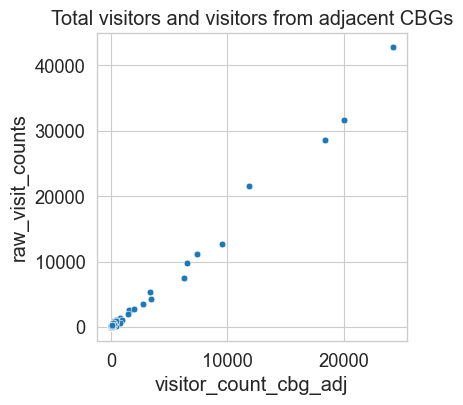

In [11]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(x='visitor_count_cbg_adj', 
                y='raw_visit_counts', 
                data=df, 
                ax=ax)
ax.set_title("Total visitors and visitors from adjacent CBGs")

In [14]:
df[hourcolumnstr]

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,0.000000,0.000000,0.000000,0.254134,0.000000,0.000000,0.315840,0.856349,0.631092,0.351593,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.037490,0.034320,0.038528,0.028410,0.029876,0.058932,0.082651,0.255475,0.403635,0.452990,...,0.641235,0.579140,0.613690,0.571292,0.567368,0.429517,0.280074,0.217231,0.088715,0.068116
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.461278,0.000000,...,0.677914,0.770301,0.718519,0.576772,0.435026,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.122232,0.081816,0.056973,0.096548,0.111264,0.246166,0.332562,0.630012,0.806469,0.729791,...,1.033178,0.887575,0.862063,0.860887,0.866129,0.539109,0.521694,0.344433,0.196093,0.155860
4,0.106557,0.000000,0.000000,0.000000,0.094856,0.105472,0.106557,0.604313,1.145035,0.928428,...,0.284785,0.283778,0.296661,0.261714,0.236595,0.188401,0.214642,0.124046,0.152054,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4314,0.100258,0.090793,0.090031,0.100768,0.102028,0.187038,0.321998,0.428800,0.478647,0.479980,...,0.621047,0.607943,0.475882,0.483389,0.457238,0.471759,0.432619,0.431413,0.416209,0.145069
4315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.025203,1.091484,0.640177,...,0.918748,0.923931,1.489695,1.370169,1.185916,1.080024,0.797252,0.317817,0.376470,0.166513
4316,0.115321,0.000000,0.104282,0.144695,0.104412,0.104097,0.288281,0.520362,0.824082,0.837853,...,1.181607,1.500381,1.298849,1.288067,1.235450,0.998768,0.950816,0.323792,0.325597,0.178750
4317,0.130333,0.120144,0.130137,0.000000,0.120495,0.122937,0.502431,2.550576,2.279740,1.405552,...,0.749804,1.300458,0.924674,1.026038,1.121556,0.984979,0.830269,0.511820,0.338469,0.150764


In [21]:
# we convert the data into long format for ease of visualization
df_long = pd.melt(df, id_vars=['st_id'], value_vars=hourcolumnstr).rename(columns={'variable':'hour', 'value':'visitor_count'})

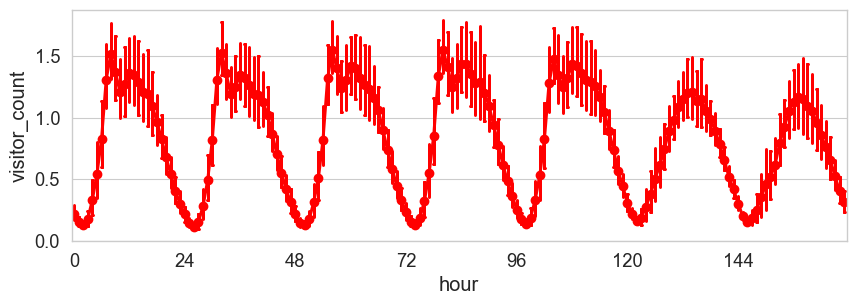

In [20]:
fig, ax = plt.subplots(figsize=(10,3))
sns.pointplot(data=df_long,
               x = "hour",
                y = "visitor_count",
                capsize=.1,
            ax=ax,
            color = 'red'
            )
# only plot major xticks
ax.set_xticks(np.arange(0,168,24))
ax.set_ylabel("Number of unique visitors")

In [ ]:

# DEFINE HELPER FUNCTIONS
def construct_vec(arr, log10):
    #Construct vector: pattern only
    if arr.sum() != 0:
        if log10:
            arr = np.log10(arr + 1)
        pattern = arr / arr.sum()
        return pattern
    else:
#         return arr
        return np.zeros(arr.shape[0])

def f_cmeans(pattern_df, n_clusters, log10, standardize, random_state):
    '''
    input: 
    pattern_di: dictionary of ID-Pattern pairs
    beta: beta value to balance volume and pattern
    n_clusters: number of clusters
    vector_mode: 1 or 2, 1 means construct vector from paper, 2 means our own method
    output:
    ndarry, cluster result for each id
    '''
    # construct vector
    data = np.zeros(pattern_df.shape)
    if type(pattern_df) == pd.core.frame.DataFrame:
        for count, idx in enumerate(pattern_df.index):
            data[count, :] = construct_vec(pattern_df.iloc[count], log10)
    elif type(pattern_df) == np.ndarray:
        for count in range(pattern_df.shape[0]):
            data[count, :] = construct_vec(pattern_df[count, :], log10)
    
    # standardize the data
    if standardize:
        scaler = StandardScaler().fit(data)
        data = scaler.transform(data)
    
    # fit data into fuzzy-c-means model
    fcm = FCM(n_clusters=n_clusters, random_state=random_state)
    fcm.fit(data)
    
    return fcm, data

def inertia_array(fcm, data):
    dist = 0
    prediction = fcm.predict(data)
    centers = fcm.centers
    for idx in range(len(prediction)):
        center = centers[prediction[idx],:]
        dist += ((center - data[idx,:]) ** 2).sum()
    return dist

def best_c_elbow(pattern_df,figname, log10, standardize, random_state, c_min=2, c_max=11):
    wss = []
    for i in range(c_min, c_max):
        fcm, data = f_cmeans(pattern_df, i, log10, standardize, random_state=random_state)
        wss.append(inertia_array(fcm, data))

    plt.figure(figsize=(6,4))
    sns.set(style="whitegrid")
    sns.set_context("paper", rc={"font.size":10,"axes.titlesize":12,"axes.labelsize":12})
    plt.plot(range(c_min,c_max), wss, 'bx-', color='black')
    plt.xlabel('Number of clusters $k$')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method showing the optimal $k$')
    plt.savefig(os.path.join(figpath,"elbow_{}.png".format(figname)), dpi=600, bbox_inches = 'tight')
    plt.show()
    
    
def silhouette_crv(pattern_df,figname, log10, standardize, random_state, c_min=2, c_max=16):
    scores = [0]
    for i in range(c_min, c_max):
        fcm, data = f_cmeans(pattern_df, i, log10, standardize, random_state=random_state)
        prediction = fcm.predict(data)
        score = silhouette_score(data, prediction)
        scores.append(score)
    sns.set(style="whitegrid")
    sns.set_context("paper", rc={"font.size":10,"axes.titlesize":12,"axes.labelsize":12})
    plt.figure(figsize=(6,4))
    plt.plot(range(c_min-1,c_max), np.array(scores), 'bx-', color='black')
    plt.xlabel('Number of clusters $k$')
    plt.ylabel('Average Silhouette')
    plt.title('The Silhouette Method showing the optimal $k$')
    plt.savefig(os.path.join(figpath,"silhouette_{}.png".format(figname)), dpi=600, bbox_inches = 'tight')
    plt.show()
    
    
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, clusterer, pointlabels=None):
    cluster_labels = clusterer.predict(X)
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X[:, 0]
    ys = X[:, 1]
    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters
    centers = clusterer.centers
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
def sample_num(prediction):
    for i in range(prediction.max() + 1):
        print((prediction == i).sum())